In [162]:
import pandas as pd
import numpy as np
import glob
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

### Declare Global variable

In [227]:
IMG_HEIGHT = 50
IMG_WEIDTH = 200
DATA_DIR = 'archive/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCH = 5

#### Data Visulization

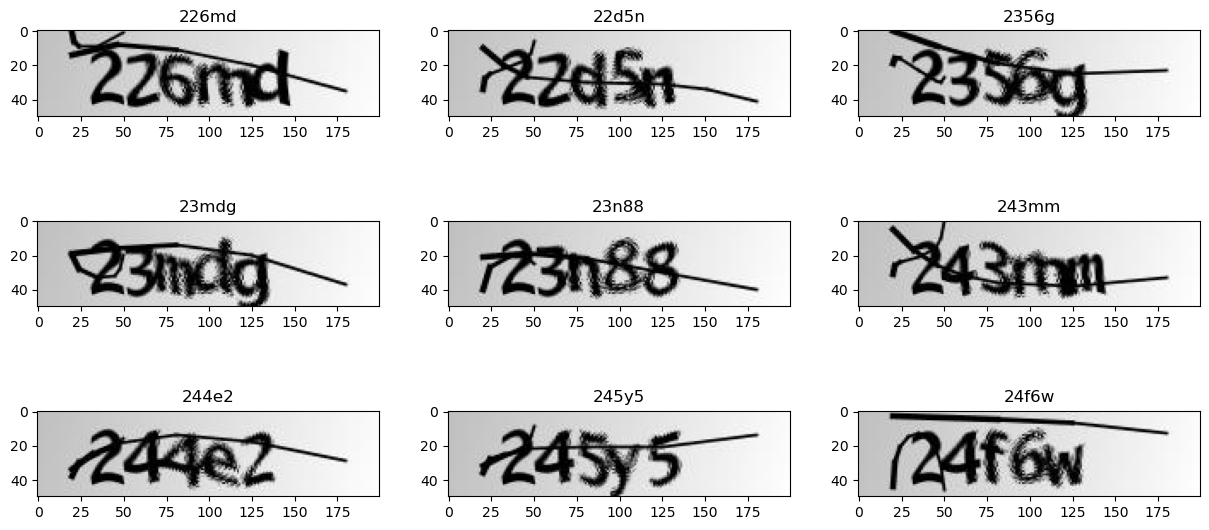

In [42]:
plt.figure(figsize=(15,7))
for ind,img_path in enumerate(glob.glob(DATA_DIR+'*.png')[:9]):
    plt.subplot(3,3,ind+1)
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.title(img_path.split('\\')[-1][:5])

## Data Prepration

In [154]:
list_of_img = glob.glob(DATA_DIR+'*.png')
df = pd.DataFrame({'img_path':list_of_img})
df['label'] = df['img_path'].str.split('\\').str[-1].str[:5]
df.head(2)

,img_path,label
0,archive\226md.png,226md
1,archive\22d5n.png,22d5n


In [155]:
# drop duplicate image by label
df = df.drop_duplicates(subset=['label']).reset_index(drop=True)

In [156]:
# List of unique charcter
all_lebel = ''
for l in df.label.values.tolist():
    all_lebel += l
unique_char = set(all_lebel)
print(unique_char)

{'x', '2', 'm', '6', 'p', '3', 'f', 'c', 'n', 'b', 'd', '8', '5', 'y', '4', 'e', 'g', '7', 'w'}


In [157]:
le = LabelEncoder()
le.fit(sorted(unique_char))
df['label'] = df['label'].apply(lambda x:le.transform(list(x))+1) # add 1 because, 0 for unknown
df.head(2)

,img_path,label
0,archive\226md.png,"[1, 1, 5, 14, 10]"
1,archive\22d5n.png,"[1, 1, 10, 4, 15]"


### Pytorch Dataset Creation

In [168]:
class CpatchaDataset(Dataset):
    def __init__(self,df,resize = None) -> None:
        self.data = df
        self.resize = resize
        self.transform  = transforms.Compose([
            transforms.Resize((self.resize[0],self.resize[1])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # values are taken from ImageNet dataset as models are usually pretrained on it

        ])
    def __len__(self):
        return len(df)
    def __getitem__(self, index):
        img_path = df.loc[0,'img_path']
        targets = df.loc[index,'label']
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return {
            'image' : torch.as_tensor(img,dtype=torch.float).to(DEVICE),
            'targets' : torch.as_tensor(targets,dtype=torch.long).to(DEVICE)
        }

In [169]:
cd = CpatchaDataset(df,(IMG_HEIGHT,IMG_WEIDTH))
cd[2]['image'].shape,cd[2]['targets']

(torch.Size([3, 50, 200]), tensor([ 1,  2,  4,  5, 13]))

### Split Dataset

In [170]:
train,test = train_test_split(df,test_size=0.3,random_state=10)
val,test = train_test_split(test,test_size=0.5,random_state=10)

In [171]:
train_dataloader = DataLoader(CpatchaDataset(train,(IMG_HEIGHT,IMG_WEIDTH)),batch_size = 64)
val_dataloader = DataLoader(CpatchaDataset(val,(IMG_HEIGHT,IMG_WEIDTH)),batch_size = 64)
test_dataloader = DataLoader(CpatchaDataset(test,(IMG_HEIGHT,IMG_WEIDTH)),batch_size = 64)


## Model Creation

In [188]:
class CpatchaModel(nn.Module):
    def __init__(self,num_char) -> None:
        super().__init__()
        self.num_char = num_char
        # (n1+2*p - k)/s +1 , (n2+2*p - k)/s +1
        # n1 = 50, n2 = 200, k=3, s=1, p=1
        self.conv1 = nn.Conv2d(3,128,kernel_size=(3,3),padding=(1, 1)) #(128,50,200) 
        self.max_pool1 = nn.MaxPool2d(kernel_size=(2,2)) # (128,25,100)

        self.conv2 = nn.Conv2d(128,64,kernel_size=(3,3),padding=(1, 1)) # (64,25,100)
        self.max_pool2 = nn.MaxPool2d(kernel_size=(2,2)) # (64,12,50)

        self.liear = nn.Linear(768,64) # 64*12
        self.dropout1 = nn.Dropout(0.2)

        self.gru = nn.GRU(64,32,bidirectional=True, num_layers=2, dropout=0.2)
        self.output = nn.Linear(64,num_char+1)

    def forward(self,image,target):
        batch_size,_,_,_ = image.size()
        x = self.conv1(image)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = self.max_pool2(x)

        x = torch.permute(x,(0,3,1,2))

        x = x.view(x.size()[0],x.size()[1],-1)  # batch_size , 75, 1152

        x = self.liear(x)
        x = self.dropout1(x)
        x,_ = self.gru(x)
        x = self.output(x)

        x = x.permute(1, 0, 2)
        if target is not None:
            log_softmax_values = F.log_softmax(x, 2)
            input_length = torch.full(
                size=(batch_size, ), fill_value=log_softmax_values.size(0), dtype=torch.int32
            )
            target_length = torch.full(
                size=(batch_size,), fill_value=target.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_softmax_values, target, input_length, target_length
            )
            return x, loss

        return x, None


### Training

In [189]:
model = CpatchaModel(len(le.classes_)+1)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

In [225]:
def decode_pred(batch_pred,label_encoder):
    decode_pred = []
    pred = batch_pred.permute(1,0,2)
    pred = torch.softmax(pred,2)
    perd = torch.argmax(pred,2)
    perd = perd.detach().cpu().numpy()
    for pre in perd:
        temp = ''
        for t in pre:
            t = t-1
            if t==-1:
                temp += '*'
            else:
                temp += label_encoder.inverse_transform([t])[0]
        decode_pred.append(temp)
    return decode_pred

In [226]:
def train_model(model,dataloader,optimizer):
    total_loss = 0
    model.train()
    for ds in dataloader:
        image = ds['image']
        target = ds['targets']
        optimizer.zero_grad()
        output,loss = model(image,target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(dataloader)

def eval_model(model,dataloader):
    total_loss = 0 
    pred = []
    model.eval()
    with torch.no_grad():
        for ds in dataloader:
            image = ds['image']
            target = ds['targets']
            output,loss = model(image,target)
            pred.append(output)
            total_loss += loss.item()
    return pred,total_loss/len(dataloader)

In [228]:
for epoch in range(EPOCH):
    train_loss = train_model(model,train_dataloader,optimizer)
    pred,loss = eval_model(model,test_dataloader)
    # alctual_pred = [decode_pred(i) for i in pred]
    val_preds_tmp = []
    for vp in pred:
        vp = decode_pred(vp, le)
        val_preds_tmp.extend(vp)
    pred = val_preds_tmp
    print(f"Epoch: {epoch+1}, Train loss: {train_loss}, Val loss: {loss}")
    print(list(zip(test.label.values.tolist(), pred))[:5])


Epoch: 1, Train loss: 3.438130266526166, Val loss: 3.3891818523406982
[(array([16, 14, 13,  4,  4]), '**************************************************'), (array([ 7,  9,  1,  2, 12]), '**************************************************'), (array([ 9, 17, 14, 15, 19]), '**************************************************'), (array([15,  8,  1,  5,  6]), '**************************************************'), (array([18, 15, 15,  9,  2]), '**************************************************')]
Epoch: 2, Train loss: 3.385711936389699, Val loss: 3.363467679304235
[(array([16, 14, 13,  4,  4]), '**************************************************'), (array([ 7,  9,  1,  2, 12]), '**************************************************'), (array([ 9, 17, 14, 15, 19]), '**************************************************'), (array([15,  8,  1,  5,  6]), '**************************************************'), (array([18, 15, 15,  9,  2]), '**************************************************')]
Epoch: 3,